# Data import

## Library definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import scipy.signal
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
from sklearn.utils import resample as bootstrap

from IPython.display import display, Math

In [2]:
class SliceMeasurement:
    
    def __init__(self, utm_path, fsr_path):
        self.utm_path = utm_path
        self.fsr_path = fsr_path
        
    def dataImport(self):
        utm_meas = pd.read_csv(self.utm_path, skiprows=11)
        self.utm_force = utm_meas["(N)"].squeeze().reset_index(drop=True).to_numpy()
        
        logger = pd.read_csv(self.fsr_path, skiprows=5).dropna()
        fsr_voltage = logger["C1 DC (V)"].squeeze()[::-1].reset_index(drop=True).to_numpy()
        
        self.fsr_v_filt = np.delete(fsr_voltage, np.where(fsr_voltage < 0.25))

        ## Normalize (Min-Max) vectors
        self.utm_norm = (self.utm_force-np.min(self.utm_force))/(np.max(self.utm_force)-np.min(self.utm_force))
        self.fsr_norm = (self.fsr_v_filt-np.min(self.fsr_v_filt))/(np.max(self.fsr_v_filt)-np.min(self.fsr_v_filt))
        
    def crossCorrelation(self):
        
        self.dataImport()
        
        standard_length = len(self.utm_norm)
        size_difference = len(self.fsr_norm) - standard_length

        correlation = np.zeros(size_difference)

        for i in range (size_difference):
            trimmed_sample = self.fsr_norm[i : standard_length + i]
            correlation[i] = np.corrcoef(self.utm_norm, trimmed_sample)[1,0]
            
        max_corr_index = np.where(correlation == max(correlation))[0][0]
        self.fsr_max_corr = self.fsr_v_filt[max_corr_index : standard_length + max_corr_index]
        
        return self.utm_force, self.fsr_max_corr
    
    def derivativeCriteria(self):
        
        self.dataImport()
        
        standard_length = len(self.utm_norm)
        fsr_diff = np.diff(self.fsr_norm[0:1000])
        slice_index = (np.where(fsr_diff == max(fsr_diff))[0][0])
        
        self.fsr_der = self.fsr_v_filt[slice_index : standard_length + slice_index]
        
        return self.utm_force, self.fsr_der

In [3]:
# Function to calculate the power law y = ax^b + c
def powerLaw(x, a, b, c):
    return a*np.power(x,b) + c

# Function for the quadratic fitting y = ax^2 + bx + c
def quadraticFit(x, a, b, c):
    return a*x**2 + b*x + c

# Function to calculate the power law y = x^a * e^(b*x) + c
def powerLawExponential(x, a, b, c):
    return np.power(x,a) * np.exp(b * x) + c

# Function for the cubic fittin y = ax^3 + bx^2 +cx + d
def cubicFit(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d



def regressionStatistics(x, y, f):
    ### Bootstrap Monte Carlo confidence intervals computation
    #nboot = 5 # number of boots
    #bspreds = np.zeros((nboot, y.size)) # bootstrap predictions

    #for i in range(nboot):
    #    xb,yb = bootstrap(x,y)
    #    pars, cov = curve_fit(f,xb,yb)
    #    bspreds[i] = f(x,*pars)
        


    # Fit the curve with all the points
    pars, cov = curve_fit(f, x, y)
    # Standard deviation of the constants
    stdev = np.sqrt(np.diag(cov))

    # Get the estimated curve
    y_hat = f(x, *pars)


    # Statistical parameters
    n = len(y) # number of data points
    p = len(pars) # number of parameters

    dof = max(0, n-p) # number of degrees of freedom

    res = y - y_hat # Residuals
    RSS = np.sum((res)**2) # Residual sum of squares -> chi^2
    variance = RSS/dof # mean residual variance, reduced chi^2
    RMSE = np.sqrt(variance)
    TSS = np.sum(y**2)
    R2 = 1 - (RSS/TSS)
    
    
    
    """
    # Parameters confidence region
    alpha = 0.05 # 95% Confidence interval 100*(1-alpha)
    # student-t value for the dof and confidence level (covers for the uncertainty in the sample)
    tval = t.ppf(1.0 - alpha/2., dof)

    # parameters confidence interval
    pars_max = pars + tval * stdev
    pars_min = pars - tval * stdev
    ax1.fill_between(x, powerLaw(x, *pars_min), powerLaw(x, *pars_max), alpha=0.1)
    """
    
    
    
    #return y_hat, bspreds, variance, RMSE, R2
    return y_hat, variance, RMSE, R2, pars, stdev

### Data import of one sensor acquisition example

Import UTM measurement example 1

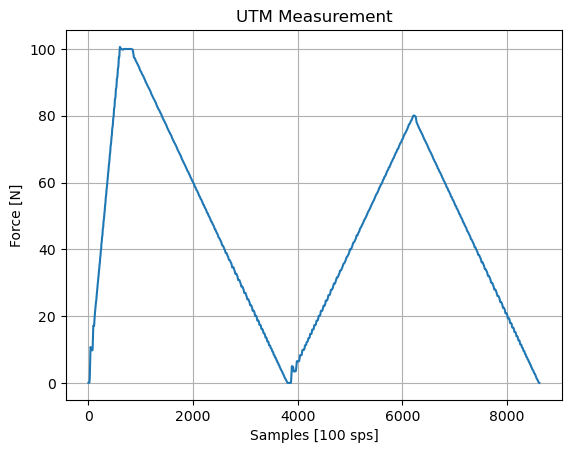

In [4]:
## UTM data import
### Skip the machine header
utm_meas = pd.read_csv('fsr_no_pluck_utm/Specimen_RawData_1.csv', skiprows=11)
utm_force = utm_meas["(N)"].squeeze().reset_index(drop=True).to_numpy()
plt.figure()
plt.plot(utm_force)
plt.grid()
plt.title("UTM Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Force [N]")
plt.show()

Import data logger example 1

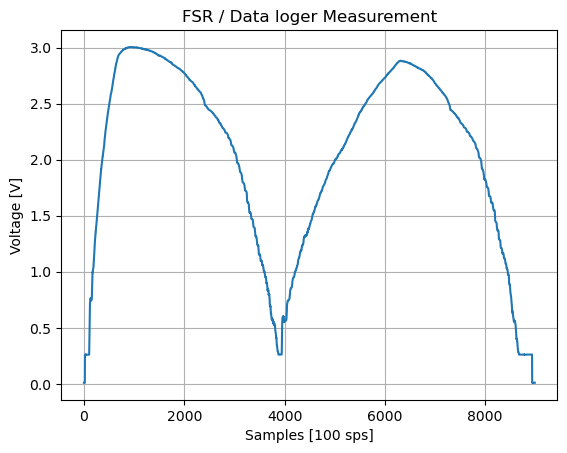

In [5]:
## Data logger import
### Skip logger header
logger = pd.read_csv('fsr_no_pluck_acq/FSR_no_pluck_1.csv', skiprows=5).dropna()
fsr_voltage = logger["C1 DC (V)"].squeeze()[::-1].reset_index(drop=True).to_numpy()
plt.figure()
plt.plot(fsr_voltage)
plt.grid()
plt.title("FSR / Data loger Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Voltage [V]")
plt.show()

Clean the lowest part of the acquisition knowing that the minimum value possible is 0.25 V by sensor design

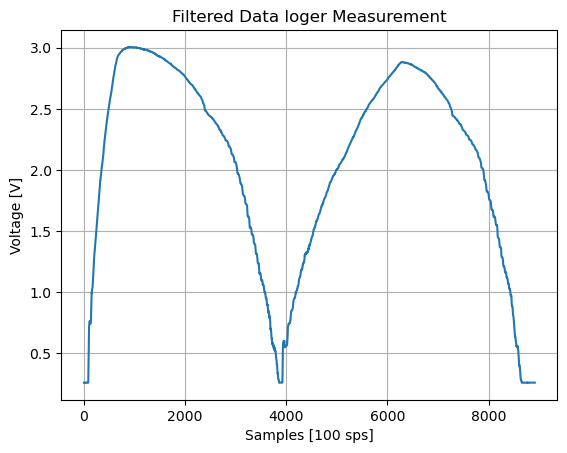

In [6]:
fsr_v_filt = np.delete(fsr_voltage, np.where(fsr_voltage < 0.25))
plt.plot(fsr_v_filt)
plt.grid()
plt.title("Filtered Data loger Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Voltage [V]")
plt.show()

### Data slicing based on max correlation example

In [7]:
## Normalize (Min-Max) vectors
utm_norm = (utm_force-np.min(utm_force))/(np.max(utm_force)-np.min(utm_force))
fsr_norm = (fsr_v_filt-np.min(fsr_v_filt))/(np.max(fsr_v_filt)-np.min(fsr_v_filt))

Maximize cross-correlation

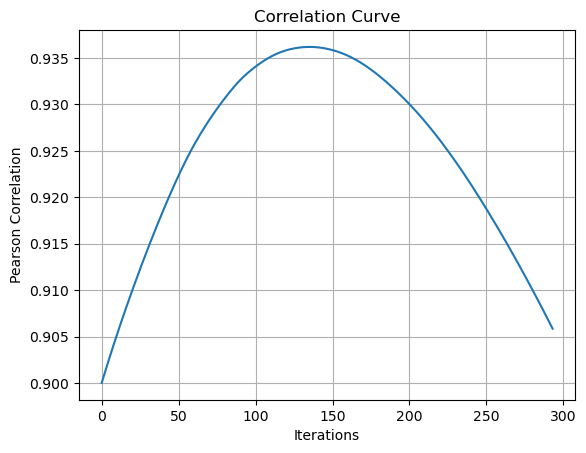

The maximum correlation index is 135


In [8]:
standard_length = len(utm_norm)
size_difference = len(fsr_norm) - standard_length

correlation = np.zeros(size_difference)

for i in range (size_difference):
    trimmed_sample = fsr_norm[i : standard_length + i]
    correlation[i] = np.corrcoef(utm_norm, trimmed_sample)[1,0]

plt.figure()
plt.plot(correlation)
plt.grid()
plt.title("Correlation Curve")
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.show()

# Slice the logger data based on the max correlation point
max_corr_index = np.where(correlation == max(correlation))[0][0]
print("The maximum correlation index is {}".format(max_corr_index))

Show the correlated plots

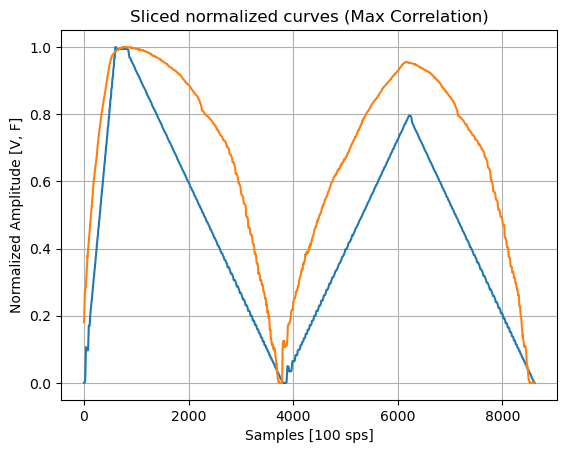

In [9]:
## Show the correlated plots
plt.figure()
plt.plot(utm_norm)
plt.plot(fsr_norm[max_corr_index : standard_length + max_corr_index])
plt.grid()
plt.title("Sliced normalized curves (Max Correlation)")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Normalized Amplitude [V, F]")
plt.show()

Slice original voltage data vector

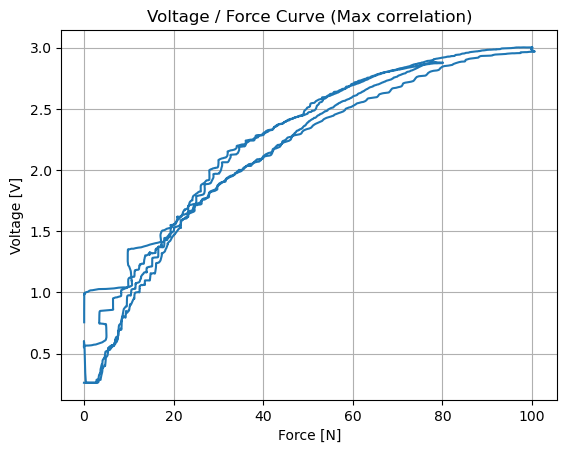

In [10]:
fsr_max_corr = fsr_v_filt[max_corr_index : standard_length + max_corr_index]

plt.figure()
plt.plot(utm_force, fsr_max_corr)
plt.grid()
plt.title("Voltage / Force Curve (Max correlation)")
plt.xlabel("Force [N]")
plt.ylabel("Voltage [V]")
plt.show()

## Process all the acquisition folders

Define the sample directory

In [11]:
directory_utm = 'microfluids_utm'
directory_fsr = 'microfluids_acq'

utm_path = []
fsr_path = []

Get all the files inside the directories

In [12]:
for filename in glob.iglob(f'{directory_utm}/*'):
    utm_path.append(filename)

for filename in glob.iglob(f'{directory_fsr}/*'):
    fsr_path.append(filename)

Initialize variables

In [13]:
dict_df = {}
keys = range(len(utm_path))

utm_temp = []
fsr_temp = []

Get the data

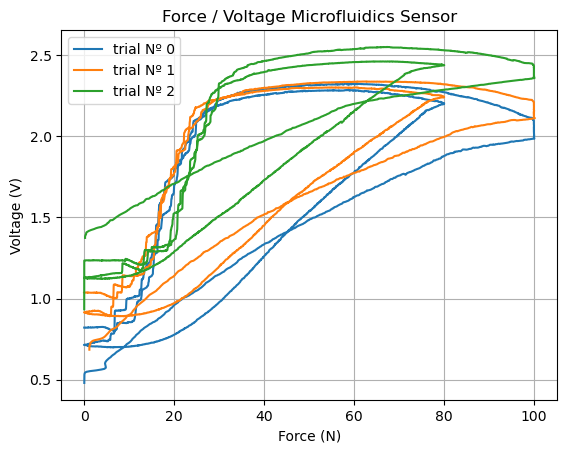

In [23]:
plt.figure()
for i in range(len(utm_path)):
    utm_temp, fsr_temp = SliceMeasurement(utm_path[i],fsr_path[i]).crossCorrelation()
    label = "trial Nº {}"
    plt.plot(utm_temp, fsr_temp, label=label.format(i))
    dict_df[i] = pd.DataFrame({'N': utm_temp, 'V': fsr_temp})
    
## Convert trials into dataframes
trials_max_correlation = pd.concat(dict_df, axis=1)
    
plt.title("Force / Voltage Microfluidics Sensor")
plt.xlabel("Force (N)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.legend()
plt.show()

In [15]:
trials_max_correlation = pd.concat(dict_df)
trials = trials_max_correlation.reset_index(drop=True)

# Preprocessing

## Low-Pass filter (20 Hz)

An IIR architecture is selected to mimick what will be implemented in firmware. 

The parameters are:
- Sampling frequency: 100sps (100 Hz)
- Cutoff frequency: 20 Hz
- Architecture: IIR Butterworth
- Order: 6

In [16]:
fs = 100
fc = 20
order = 6

# coefficients calculation for the IIR filter
b, a = scipy.signal.iirfilter(order, Wn=fc, fs=fs, btype='low', ftype='butter')
print(b, a, sep='\n')
# apply filtfilt to achieve a 0 phase effect
filtered_f =  scipy.signal.filtfilt(b, a, trials.N)
filtered_V =  scipy.signal.filtfilt(b, a, trials.V)

[0.01031287 0.06187725 0.15469312 0.2062575  0.15469312 0.06187725
 0.01031287]
[ 1.         -1.18760068  1.30521335 -0.67432753  0.26346935 -0.05175303
  0.00502253]


In [17]:
filt_trials = pd.DataFrame(list(zip(filtered_f, filtered_V)), columns = ['N', 'V'])

In [18]:
filt_trials

,N,V
0,0.017673,0.479050
1,0.016000,0.482672
2,0.017913,0.486155
3,0.021390,0.489598
4,0.021039,0.493295
...,...,...
25824,0.184332,1.234665
25825,0.130182,1.271169
25826,0.070707,1.261533
25827,0.026271,1.144320


## Moving average filter

In [19]:
ma_trials = filt_trials.rolling(50).mean()
ma_trials.dropna(inplace=True)

In [20]:
ma_trials

,N,V
49,3.571328,0.582789
50,3.739354,0.587053
51,3.911959,0.591325
52,4.088825,0.595606
53,4.269117,0.599897
...,...,...
25824,0.896475,1.234996
25825,0.866096,1.235717
25826,0.836013,1.236244
25827,0.806262,1.234427


C:\Users\danie\AppData\Local\Temp\ipykernel_37752\89298404.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(ma_trials.N[0:800], label='Filtered UTM force values', color='green')
C:\Users\danie\AppData\Local\Temp\ipykernel_37752\89298404.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(ma_trials.V[0:800], label='Filtered FSR amplitude', color='blue')


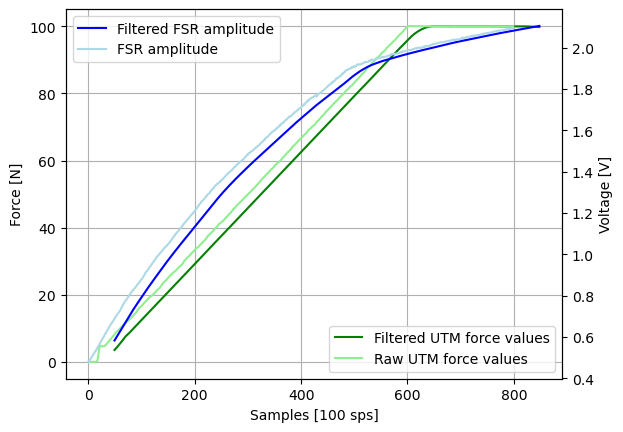

In [21]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Samples [100 sps]')
ax1.set_ylabel('Force [N]')
ax1.plot(ma_trials.N[0:800], label='Filtered UTM force values', color='green')
ax1.plot(trials.N[0:800], label='Raw UTM force values', color='lightgreen')




ax2 = ax1.twinx()

ax2.set_ylabel('Voltage [V]')
ax2.plot(ma_trials.V[0:800], label='Filtered FSR amplitude', color='blue')
ax2.plot(trials.V[0:800], label='FSR amplitude', color='lightblue')


ax1.grid()
ax1.legend(loc=4)
ax2.legend(loc=0)

## Data reorganization

Construct reverse model of the FSR

<IPython.core.display.Math object>

Regression parameters are: a = 43.53881127815765, b = 0.88287854575133, c = -29.707542559724835 
Regression parameters standard deviations are: a = 2.89238560333365, b = 0.04110794948107404, c = 2.955414031381812 
 Variance: 332.55835035940044 
 RMSE: 18.236182450266295 
 R2: 0.8824519834974855


<IPython.core.display.Math object>

Regression parameters are: a = -2.91292538930221, b = 46.133136440231155, c = -29.613580617462365 
Regression parameters standard deviations are: a = 0.48967364038929423, b = 1.6612277663665698, c = 1.2819626569366842 
 Variance: 332.22752548747025 
 RMSE: 18.227109630642765 
 R2: 0.8825689187885798


<IPython.core.display.Math object>

Regression parameters are: a = 0.5330517885939943, b = 1.4277312987645538, c = 17.507845557762913 
Regression parameters standard deviations are: a = 1.5617354999410609, b = 0.5906562410582935, c = 2.496711900792864 
 Variance: 384.77053367773334 
 RMSE: 19.61556865547704 
 R2: 0.8639967602871741


<IPython.core.display.Math object>

Regression parameters are: a = -18.997015402309437, b = 91.26985323036659, c = -99.59234691491118, d = 39.4076347605572 
Regression parameters standard deviations are: a = 0.921368888219252, b = 4.59368108296309, c = 7.257318577391924, d = 3.5809368667476056 
 Variance: 326.8498248023597 
 RMSE: 18.078988489469197 
 R2: 0.8844742341880653


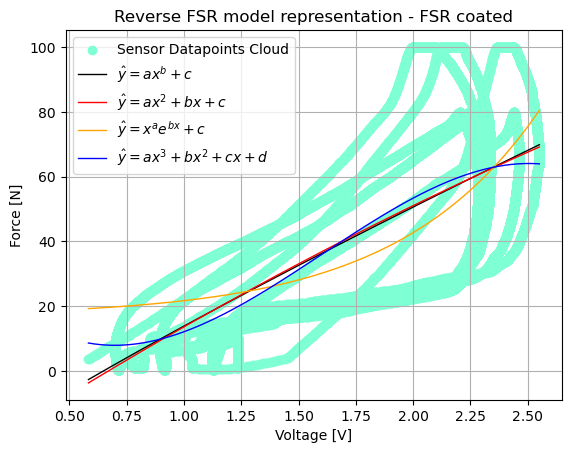

In [22]:
#Sort dataframe
sort = ma_trials.sort_values(by='V')

x = sort.V.to_numpy()
y = sort.N.to_numpy()

fig, ax = plt.subplots()

# All points plot
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('Force [N]')
ax.set_title('Reverse FSR model representation - FSR coated')
ax.scatter(x, y, label='Sensor Datapoints Cloud', color='aquamarine')


# Power Law Regression

pred, var, RMSE, R2, pars, pars_stdev = regressionStatistics(x, y, powerLaw)

info = " Variance: {} \n RMSE: {} \n R2: {}".format(var, RMSE, R2)

## Plot fitted curve
ax.plot(x, pred, linewidth=1, color='black', label = r'$\hat{y} = ax^b + c$')

head = display(Math(r'\hat{y} = ax^b + c \\'))
regression_par = "Regression parameters are: a = {}, b = {}, c = {} \n".format(*pars)
regression_par_stdev = "Regression parameters standard deviations are: a = {}, b = {}, c = {} \n".format(*pars_stdev)
print(regression_par + regression_par_stdev + info)



## Quadratic regression
pred, var, RMSE, R2, pars, pars_stdev = regressionStatistics(x, y, quadraticFit)

info = " Variance: {} \n RMSE: {} \n R2: {}".format(var, RMSE, R2)

## Plot fitted curve
ax.plot(x, pred, linewidth=1, color='red', label = r'$\hat{y} = ax^2 + bx + c$')

head = display(Math(r'\hat{y} = ax^2 + bx + c \\'))
regression_par = "Regression parameters are: a = {}, b = {}, c = {} \n".format(*pars)
regression_par_stdev = "Regression parameters standard deviations are: a = {}, b = {}, c = {} \n".format(*pars_stdev)
print(regression_par + regression_par_stdev + info)


## Power law with exponential cutoff regression
pred, var, RMSE, R2, pars, pars_stdev = regressionStatistics(x, y, powerLawExponential)

info = " Variance: {} \n RMSE: {} \n R2: {}".format(var, RMSE, R2)

## Plot fitted curve
ax.plot(x, pred, linewidth=1, color='orange', label = r'$\hat{y} = x^a e^{bx}+c$')

head = display(Math(r'\hat{y} = x^a e^{bx} + c \\'))
regression_par = "Regression parameters are: a = {}, b = {}, c = {} \n".format(*pars)
regression_par_stdev = "Regression parameters standard deviations are: a = {}, b = {}, c = {} \n".format(*pars_stdev)
print(regression_par + regression_par_stdev + info)


## Try with 3rd order curve fitting
pred, var, RMSE, R2, pars, pars_stdev = regressionStatistics(x, y, cubicFit)

info = " Variance: {} \n RMSE: {} \n R2: {}".format(var, RMSE, R2)

## Plot fitted curve
ax.plot(x, pred, linewidth=1, color='blue', label = r'$\hat{y} = ax^3 + bx^2 + cx + d$')

head = display(Math(r'\hat{y} = ax^3 + bx^2 + cx + d \\'))
regression_par = "Regression parameters are: a = {}, b = {}, c = {}, d = {} \n".format(*pars)
regression_par_stdev = "Regression parameters standard deviations are: a = {}, b = {}, c = {}, d = {} \n".format(*pars_stdev)
print(regression_par + regression_par_stdev + info)


ax.grid()
ax.legend()



# Microcontroller Implementation Assisted Calculations

## IIR Filter computation

In [23]:
fs = 200 # 200 Hz sampling freq
fc = 20 # 20 Hz cutoff freq
order = 6

# coefficients calculation for the IIR filter
b, a = scipy.signal.iirfilter(order, Wn=fc, fs=fs, btype='low', ftype='butter')
print(b, a, sep='\n')

[0.00034054 0.00204323 0.00510806 0.00681075 0.00510806 0.00204323
 0.00034054]
[ 1.         -3.5794348   5.65866717 -4.96541523  2.52949491 -0.70527411
  0.08375648]


In [24]:
fs = 200 # 200 Hz sampling freq
fc = 1 # 20 Hz cutoff freq
order = 6

# coefficients calculation for the IIR filter
b, a = scipy.signal.iirfilter(order, Wn=fc, fs=fs, btype='low', ftype='butter')
print(b, a, sep='\n')

[1.41440730e-11 8.48644379e-11 2.12161095e-10 2.82881460e-10
 2.12161095e-10 8.48644379e-11 1.41440730e-11]
[  1.          -5.87861916  14.40044053 -18.81528973  13.82942474
  -5.42164649   0.88569011]
